In [25]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
import seaborn as sns
from os.path import join
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import dvu
from copy import deepcopy
import neuro.viz
import sys
from numpy import ceil
sys.path.append('../notebooks')
from tqdm import tqdm
from neuro import config
from neuro.features.qa_questions import get_questions, get_merged_questions_v3_boostexamples
import neuro.sasc.viz
from PIL import Image
# from flatmaps_helper import VOX_COUNTS, load_custom_rois, ROI_EXPLANATIONS_S03, FED_DRIVING_EXPLANATIONS_S03, FED_DRIVING_EXPLANATIONS_S02
from neuro.flatmaps_helper import load_flatmaps, load_custom_rois, load_known_rois
import neuro.flatmaps_helper
import sys
from neuro import analyze_helper
neurosynth_compare = __import__('04_neurosynth_compare')
import neurosynth
from neuro.features.questions.gpt4 import QS_35_STABLE
import viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
subject = 'S02'
# subjects = [f'S0{i}' for i in range(1, 9) if not i == 6] # there's some problem with S06 surf2surf
subjects = ['S01', 'S02', 'S03', 'S08']

# load flatmaps
d = defaultdict(list)
for subject in subjects:
    # if subject in ['S01', 'S02', 'S03']:
    # settings = ['individual_gpt4',
    # 'individual_gpt4_wordrate', 'shapley_35']
    # else:
    settings = ['individual_gpt4_pc_new']
    flatmaps_qa_list = defaultdict(list)
    for setting in settings:
        flatmaps_qa_dict = joblib.load(
            join(config.PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
        for q in flatmaps_qa_dict.keys():
            flatmaps_qa_list[q].append(flatmaps_qa_dict[q])
    flatmaps_qa_dict = {
        q: np.mean(flatmaps_qa_list[q], axis=0)
        for q in flatmaps_qa_list.keys()
    }
    # for k in sorted(flatmaps_qa_dict.keys()):
    for k in QS_35_STABLE:
        # print(k, flatmaps_qa_dict[k])
        # d[f'q_{subject}'].append(k)
        d[subject].append(flatmaps_qa_dict[k])

    # print(subject, len(flatmaps_qa_dict))
df = pd.DataFrame(d)
# df.set_index('q_S01', inplace=True)
df.index = QS_35_STABLE
df.index.name = 'question'
df = df[df.index.isin(QS_35_STABLE)]
assert df.shape[0] == 35

In [32]:
data = joblib.load(join(config.RESULTS_DIR_LOCAL, 'results_best_ensemble.pkl'))
rr, cols_varied, mets = data['r'], data['cols_varied'], data['mets']
metric_sort = 'corrs_tune_pc_weighted_mean'
rr_best = rr[(rr.pc_components == 100) *
             (rr.ndelays == 8) *
             (rr.feature_space.str.contains('qa_emb')) *
             (rr.feature_selection_alpha < 0) *
             (rr.num_stories == -1) *
             (rr.qa_embedding_model == 'ensemble2')
             ]  # .sort_values(by='corrs_test_mean').iloc[-1]

### Select avg-response flatmaps

In [ ]:
# select
avg_defaultdict = defaultdict(list)
for subject in ['S02']:  # , 'S02']:
    qa_flatmaps_dict = df[subject].to_dict()

    # rois_dict = neuro.flatmaps_helper.load_known_rois(subject)
    rois_dict = neuro.flatmaps_helper.load_custom_rois(
        subject, suffix_setting='_lobes')

    corrs_35 = rr_best[rr_best.subject == subject]['corrs_test'].iloc[0]
    sig_well_predicted = corrs_35 > 0.1
    # for k in rois_dict.keys():
    # rois_dict[subject + ' lang\n(ρ>0.1)'] = sig_well_predicted & sig
    # rois_dict[subject + ' non-lang\n(ρ>0.1)'] = sig_well_predicted & ~sig

    ##################################################
    # compute means
    # avg_defaultdict = defaultdict(list)
    for roi_idx, roi in rois_dict.items():
        for explanation in qa_flatmaps_dict.keys():
            avg_defaultdict[roi_idx].append(
                np.mean(qa_flatmaps_dict[explanation][roi > 0]))
            # corrs_defaultdict[roi_idx].append(
            # np.corrcoef(roi, gemv_flatmaps_dict[explanation])[0, 1])

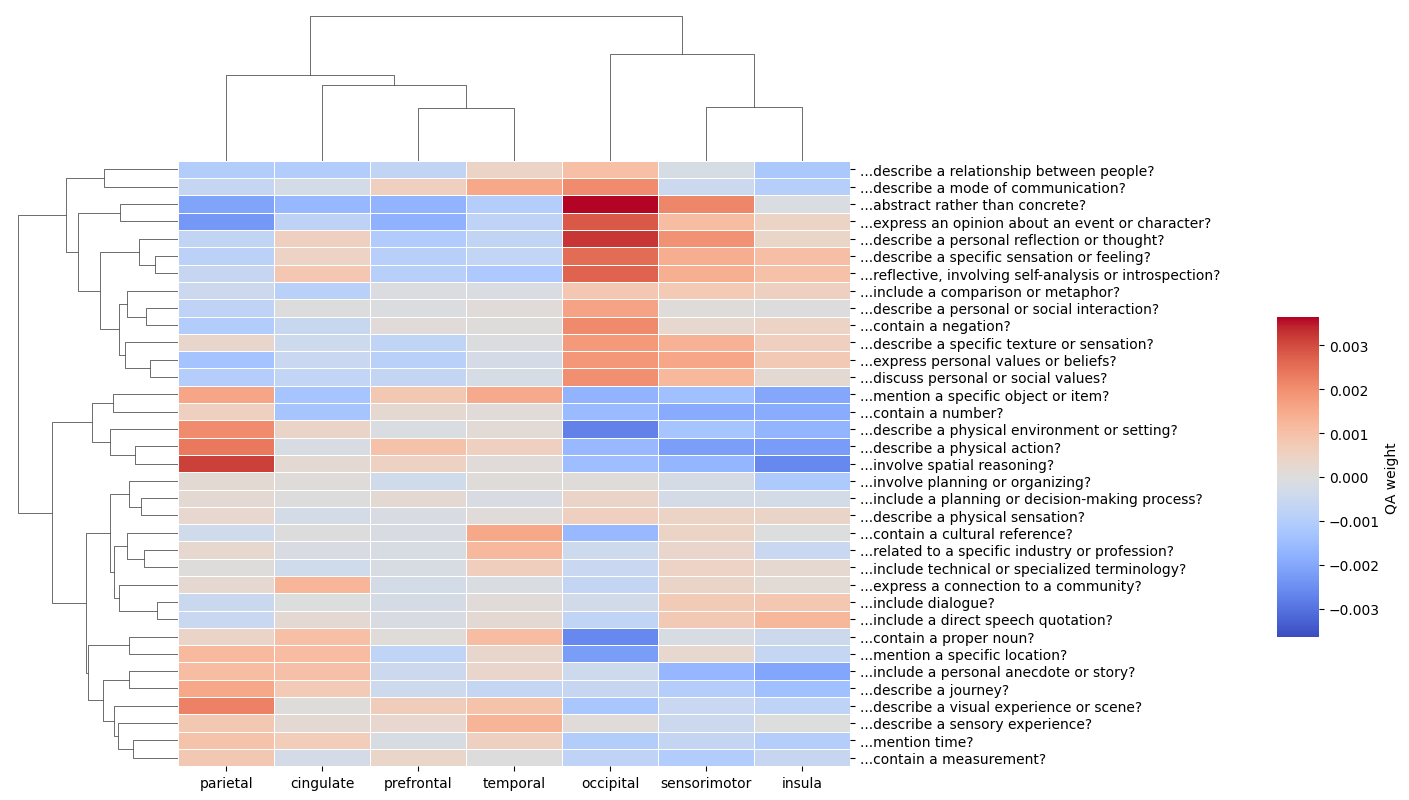

In [49]:
d = pd.DataFrame(avg_defaultdict, index=qa_flatmaps_dict.keys())
# d['AVG'] = d.mean(axis=1)

# remove 2nd val of index
d.index = [analyze_helper.abbrev_question(q) for q in d.index]

# d = d.sort_values('AVG', ascending=False)  # * 1000
# display pandas formatting with redblue colormap centered at 0 rounded to 3 decimal places
vabs = max(abs(d.values.min()), abs(d.values.max()))
# d.style.background_gradient(cmap='coolwarm', axis=None, vmax=vabs, vmin=-vabs).format("{:.2f}").set_caption(
# 'Average QA coefficients for different voxel subsets'
# )

sns.clustermap(d, annot=False, fmt='.3f', cmap='coolwarm', center=0, vmin=-vabs, vmax=vabs,
               annot_kws={"size": 10}, cbar_kws={"label": "QA weight"}, linewidths=.5)

# move colorbar to the right
plt.gcf().axes[-1].set_position([.92, .2, .03, .4])

# make plot wider
plt.gcf().set_size_inches(14, 8)
plt.savefig('qa_rois_matrix.png', dpi=300, bbox_inches='tight')

# make top-voxel fig

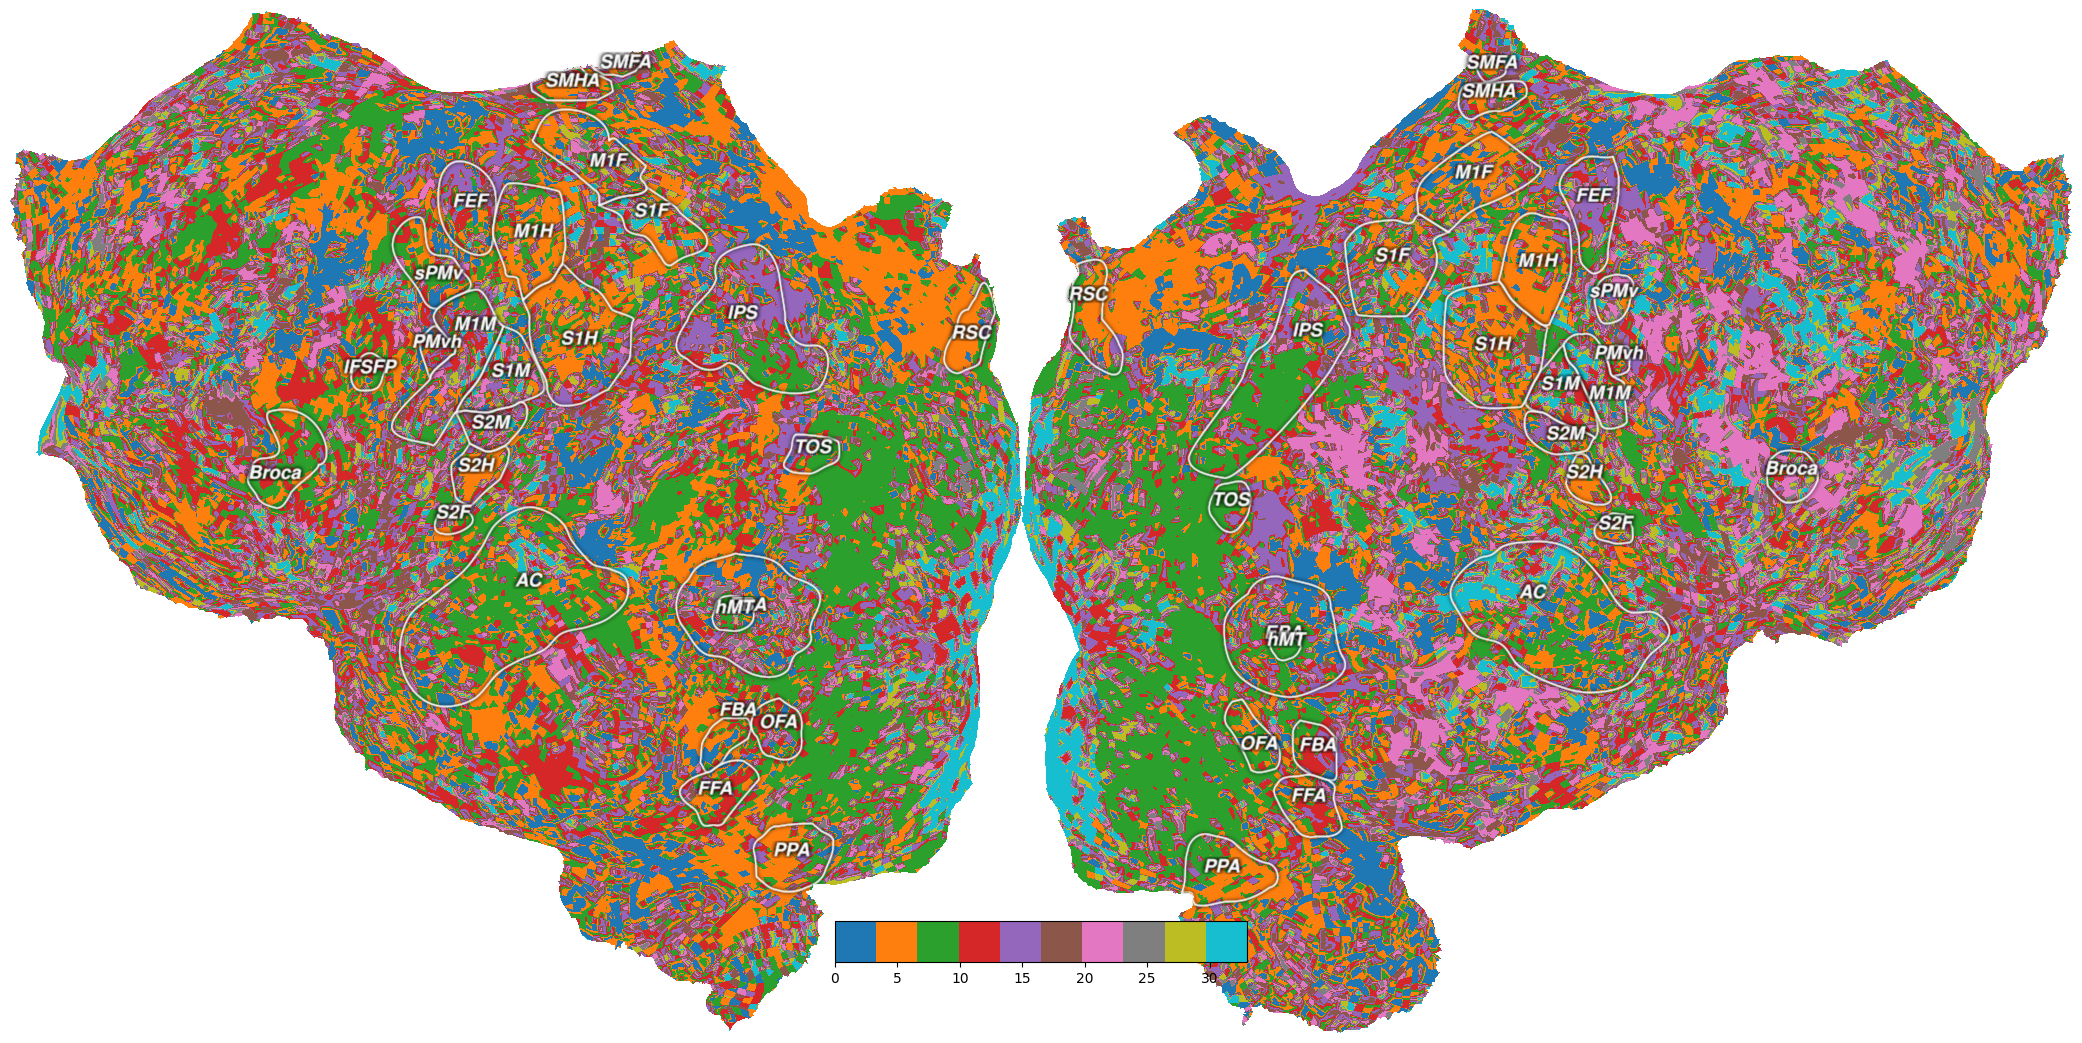

In [115]:
subject = 'S03'
top_q_flatmap = np.vstack(df['S03'].values).argmax(axis=0)
neuro.viz.quickshow(top_q_flatmap, subject=subject, cmap='tab10', center=False)

In [103]:
# {i: q for (i, q) in enumerate(df.index)}

In [116]:
remap = {
    'Misc': (0, {
        1: 'Does the sentence contain a proper noun?',
        7: 'Does the sentence mention a specific location?',
        11: 'Is the input related to a specific industry or profession?',
        14: 'Does the input involve planning or organizing?',
        19: 'Does the sentence include technical or specialized terminology?',
        21: 'Does the sentence contain a cultural reference?',
        24: 'Does the sentence express a sense of belonging or connection to a place or community?',
        25: 'Does the sentence describe a specific sensation or feeling?',
        26: 'Does the text include a planning or decision-making process?',
        27: 'Does the sentence include a personal anecdote or story?',
        29: 'Does the text describe a journey?',
        31: 'Does the sentence describe a physical sensation?',
        34: 'Does the input describe a specific texture or sensation?',
    }),
    'Visual':  (1, {
        13: 'Does the sentence describe a visual experience or scene?',
        18: 'Does the sentence describe a sensory experience?',
        15: 'Does the sentence involve spatial reasoning?',
        2: 'Does the sentence describe a physical action?',
        5: 'Does the sentence involve a description of physical environment or setting?',
        # questionable
        4: 'Does the sentence involve the mention of a specific object or item?',
    }),
    'Social': (2, {
        3: 'Does the sentence describe a personal or social interaction that leads to a change or revelation?',
        6: 'Does the sentence describe a relationship between people?',
        22: 'Does the text describe a mode of communication?',
        12: 'Does the sentence include dialogue?',
        32: 'Does the sentence include a direct speech quotation?',
    }),
    'Numeric': (3, {
        8: 'Is time mentioned in the input?',
        20: 'Does the input contain a number?',
        30: 'Does the input contain a measurement?',
    }),
    'Abstract / Opinion': (4, {
        23: 'Does the input include a comparison or metaphor?',
        10: "Does the sentence express the narrator's opinion or judgment about an event or character?",
        16: 'Does the sentence involve an expression of personal values or beliefs?',
        28: 'Does the sentence involve a discussion about personal or social values?',
        17: 'Does the sentence contain a negation?',
        9: 'Is the sentence abstract rather than concrete?',
        0: 'Does the sentence describe a personal reflection or thought?',
        33: 'Is the sentence reflective, involving self-analysis or introspection?',
    }),
}

In [117]:
top_q_flatmap_remapped = deepcopy(top_q_flatmap)
for category_name, v in remap.items():
    num_new = v[0]
    remap_nums = v[1]
    for num_old in remap_nums.keys():
        top_q_flatmap_remapped[top_q_flatmap == num_old] = num_new

In [118]:
neuro.viz.quickshow(
    top_q_flatmap_remapped.astype(int),
    subject=subject,
    cmap=len(np.unique(top_q_flatmap_remapped)),
    center=False,
    with_colorbar=False,
    fname_save='qa_rois_flatmap.png',
)

In [ ]:
# top_q_flatmap_remapped_masked = top_q_flatmap_remapped.astype(float)
# top_q_flatmap_remapped_masked[corrs_35 < 0.1] = np.nan
# neuro.viz.quickshow(
#     top_q_flatmap_remapped_masked.astype(int),
#     subject='UTS02',
#     cmap=len(np.unique(top_q_flatmap_remapped_masked)),
#     center=False,
#     with_colorbar=False,
#     fname_save='qa_rois_flatmap_masked.png',
# )

/tmp/ipykernel_265582/1445436743.py:4: RuntimeWarning: invalid value encountered in cast
  top_q_flatmap_remapped_masked.astype(int),


<Figure size 1000x200 with 0 Axes>

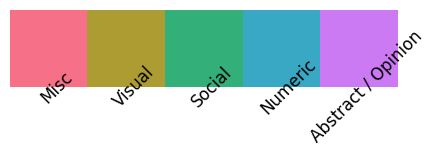

In [112]:
# save color pallete as a colorbar
plt.figure(figsize=(10, 2))
sns.palplot(sns.color_palette("husl", 5))
plt.axis('off')
# add labels
for i, category_name in enumerate(remap.keys()):
    plt.text(i + 0.1, 0.5, category_name,
             ha='center', va='center', fontsize=12, rotation=45)
plt.savefig('qa_rois_flatmap_palette.png', dpi=300, bbox_inches='tight')